In [3]:
import gym
from gym import wrappers
import chemo_simulation # custom cart-pole environment

import numpy as np
import pandas as pd

from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [50]:
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # Initialize environment
    env = gym.make(env_name)

    # Partition the action space to a given number of actions
    part_act_space = np.linspace(env.action_space.low[0]
                                 ,env.action_space.high[0], n_actions)
    
    return part_act_space


In [55]:
partition_action_space(env_name='ChemoSimulation-v0', n_actions = 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [4]:
# Initial patient set
tumor_size_init, toxicity_init = np.random.uniform(low=0, high=2, size = (2, 1000))
init_patients = [(t_size, toxicity) for t_size, toxicity in zip(tumor_size_init,toxicity_init)]

# Dosages to provide to patient
dosage_levels = np.array([0.1 , .3 , .5, .7, .1])

# Random policy to use
def random_policy(env):
    return env.action_space.sample()

#### Evaluate preferences

In [8]:
from statsmodels.stats.descriptivestats import sign_test

def evaluate_preference(starting_state # starting state of roll-outs
                        , action_1     # first action to execute at the starting-state
                        , action_2     # second action to execute at the starting state
                        , policy_in    # policy to folow
                        , environment_name = 'ChemoSimulation-v0'   # name of the environment
                        #, discount_fac = 1        # discounting factor
                        , n_rollouts = 10         # number of roll-outs to generate per action
                        , max_rollout_len = 7     # maximum length of a roll-out
                        , label_ranker = False    # whether to use the label-ranking model or not
                        , modified_algo = False   # Whether evaluations run for modified algorithm or not
                        , p_sig = 0.1            # p-value to use for t-test (to compare returns of roll-outs)
                        , tracking = False
                        ):
    
    """
    Description:
    
        - Roll-outs are generated at each state in the initial state set by starting from the given input action 
          and following the given policy afterwards. 
        - Returns of the roll-outs are used to generate preferences for the input action pair.
        - Generated preferences are returned to be create a training dataset to learn the LabelRanker model.    
    """
    
    # initializing variables
    policy = policy_in          
    n_rollouts = n_rollouts     
    #gamma = discount_fac    
    s_init = starting_state
    max_traj_len = max_rollout_len 
        
    # we store the num. actions executed within the evaluation process (to measure complexity)
    action_count = 0 
        
    # Dictionary to store input action values
    actions = { 'one' : action_1    
              , 'two' : action_2}    

    # Dictionary to store tumor sizes at the end of roll-outs
    t_mass = { 'one' : [None]*n_rollouts 
              , 'two' : [None]*n_rollouts}

    # Dictionary to store max toxicity values of roll-outs
    toxicity = { 'one' : [None]*n_rollouts 
              , 'two'  : [None]*n_rollouts}  

    # Dictionary to store the probability of death at the end of roll-outs
    prob_death = { 'one' : [None]*n_rollouts 
                  , 'two'  : [None]*n_rollouts}  

    # Dictionary to rollout-preferences for each action
    accu_preferences = {'one': 0, 'two': 0}  

    # List to store sign-test data of rollouts
    sign_test_vals = [None] * n_rollouts
    
    # Generate the defined number of roll-outs for selected action
    for rollout in range(n_rollouts):

        # Select each starting action of the input actions to generate a roll-out
        for action_key, action_value in actions.items():

            # Create an environment object and set the starting state to the input (initial) state
            env = gym.make(environment_name)
            env.reset(init_state=s_init) 

            # Apply the action
            observation, reward, done, _ = env.step(np.array([action_value]))
            
            # Define the history variable to store the last observed state
            hist = observation 
            
            # Variables to store the last tumor-size, max-toxicity, and the probab. of death of a rollout
            max_toxicity  = -1_000
            last_t_mass   = None
            last_p_death  = None

            # Follow the given policy to generate a roll-out trajectory 
            traj_len = 1
            while traj_len < max_traj_len and not done: 
                                
                # Sample next state using the label-ranking model (if TRUE)
                if label_ranker: 
                    observation, reward, done, p_death = env.step(policy.label_ranking_policy(hist))

                    # Replace current history with the observed state
                    hist = observation
                    action_count+=1   # Increase the action count by 1
                
                else:
                    # Sample next state using a random policy 
                    observation, reward, done, p_death = env.step(policy(env))
                    action_count += 1 # Increase the action count by 1

                # Increment the trajectory length count by 1
                traj_len += 1

                # Update the placeholder variables with latest values
                last_t_mass  = observation[0]
                max_toxicity = max(max_toxicity, observation[1])
                last_p_death = p_death

            # Store the last observed rollout information
            t_mass[action_key][rollout]     = last_t_mass
            toxicity[action_key][rollout]   = max_toxicity
            prob_death[action_key][rollout] = last_p_death

            # close the environment after creating all roll-outs for a specific starting action
            env.close()
            del env


        # Generate preference relation information for the rollout
        if (np.round(prob_death['one'][rollout],2)  >= 1.0) and (np.round(prob_death['two'][rollout],2) >= 1.0):
            continue

        elif (np.round(prob_death['one'][rollout],2)  < 1.0) and (np.round(prob_death['two'][rollout],2) >= 1.0):
            # Patient survives for the trajectory starting from action 'one'
            accu_preferences['one'] += 1
            sign_test_vals[rollout] = +1

        elif (np.round(prob_death['one'][rollout],2) >= 1.0) and (np.round(prob_death['two'][rollout],2) < 1.0):
            # Patient survives for the trajectory starting from action 'two'
            accu_preferences['two'] += 1
            sign_test_vals[rollout] = -1


        elif (np.round(prob_death['one'][rollout],2) < 1.0) and (np.round(prob_death['one'][rollout],2) < 1.0):
            # Patient survives for both trajectories starting from both actions
            
            if (np.round(toxicity['one'][rollout],4) <= np.round(toxicity['two'][rollout],4)) and \
               (np.round(t_mass['one'][rollout],4)  <= np.round(t_mass['two'][rollout],4)):
               # Max toxicity and tumor size of the patient starting from action 'one' is smaller
               accu_preferences['one'] += 1
               sign_test_vals[rollout] = +1

            if (np.round(toxicity['one'][rollout],4) >= np.round(toxicity['two'][rollout],4)) and \
                (np.round(t_mass['one'][rollout],4) >= np.round(t_mass['two'][rollout],4)):
                # Max toxicity and tumor size of the patient starting from action 'two' is smaller
                accu_preferences['two'] += 1

                # In case both max. toxicity and tumor size are equal for both action trajectories
                if sign_test_vals[rollout] == +1:
                    sign_test_vals[rollout] = 0
                else:
                    sign_test_vals[rollout] = -1
        
        else:
            # No preference is generated for the rollout
            accu_preferences['one'] += 0
            accu_preferences['two'] += 0
            sign_test_vals[rollout] = 0


    # Clean-up sign-test data after removing 'None' entries
    sign_test_vals = [val for val in sign_test_vals if val is not None]
    
    # Run sign-test
    m, p_val = sign_test(sign_test_vals)

    # print('mass', t_mass, '\n\ntoxicity',toxicity, '\n\np-death',prob_death)
    # print('Action 1 preferences:' , accu_preferences['one']
    #         , 'Action 2 preferences:', accu_preferences['two']
    #         , 'sign_test', sign_test_vals, 'p-val', p_val, 'm', m)

    # track output
    if tracking:
        print(f"state: {s_init} | a_j(R): {accu_preferences['one']} | a_k(R): {accu_preferences['two']} | sig: {'Yes' if (p_val <= p_sig) else '--'}")
    
    # return preference information
    if (m > 0) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}, action_count
    
    elif(m < 0) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}, action_count
    
    # return NaN if avg. returns are not significantly different from each other OR are equal
    else: 
        return {'state': np.nan
               , 'a_j' : np.nan
               , 'a_k' : np.nan
               , 'preference_label' : np.nan}, action_count

In [19]:
import itertools

act_pairs = list(itertools.combinations(dosage_levels,2))


In [46]:
action_pair[0]

0.7

In [23]:
train_data = []

for state in init_patients: # generate roll-outs from each starting state

    for action_pair in act_pairs: # generate roll-outs for each action pair

        # generate preference data & executed num. of actions in each action pair evaluation step
        preference_out, actions_per_pair = evaluate_preference(starting_state = state
                                                                , action_1       = action_pair[0]
                                                                , action_2       = action_pair[1]
                                                                , policy_in      = random_policy
                                                                #, label_ranker   = label_r_flag
                                                                #, modified_algo  = True if off_policy_exploration else False
                                                                , n_rollouts     = 39
                                                                , p_sig          = 0.1
                                                                , tracking       = True
                                                                )   

        # append the generated preference data to the training data list
        if preference_out is not None:
            train_data.append(preference_out) 
        else:
            pass



_k(R): 2 | sig: --
state: (0.2651958819383651, 0.7291505396562694) | a_j(R): 4 | a_k(R): 2 | sig: --
state: (0.2651958819383651, 0.7291505396562694) | a_j(R): 3 | a_k(R): 1 | sig: --
state: (0.2651958819383651, 0.7291505396562694) | a_j(R): 3 | a_k(R): 2 | sig: --
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 2 | a_k(R): 12 | sig: Yes
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 5 | a_k(R): 12 | sig: --
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 7 | a_k(R): 6 | sig: --
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 14 | a_k(R): 6 | sig: --
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 7 | a_k(R): 6 | sig: --
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 12 | a_k(R): 3 | sig: Yes
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 16 | a_k(R): 5 | sig: Yes
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 12 | a_k(R): 4 | sig: Yes
state: (0.7924492875325322, 1.3956133547990928) | a_j(R): 17 | a_k(R)

In [26]:
act_space

NameError: name 'act_space' is not defined

In [44]:
# generate the training dataset and learn the LabelRanker model
model = train_model(train_data     = train_data
                    , action_space = dosage_levels
                    #, model_name   = model_name 
                    #, mod_layers   = model_config
                    , batch_s      = 4
                    #, n_epochs     = epch_config 
                    #, l_rate       = l_rate_config
                    #, retrain_model = True if off_policy_exploration else False
                    #, policy_iterr_count = iterr
                    #, show_train_plot = train_plot_tracking
                    , show_dataset    = True
                    )



Training data samples: 304
                                     state_key preference_label_vector
11     0.38411412902420206_0.24713099921876713    [0.0, 0.0, 1.0, 0.0]
32       1.6271765174104775_0.7237666902615703    [2.0, 1.0, 1.0, 0.0]
55    0.12028557960072916_0.029530869023235873    [0.0, 0.0, 0.0, 1.0]
75      0.15719994731857279_0.2578232421280171    [0.0, 0.0, 0.0, 1.0]
85       1.4258817853152932_0.6882267280577505    [0.0, 1.0, 0.0, 0.0]
...                                        ...                     ...
9910     0.4710821849835225_1.6126428742772385    [0.0, 1.0, 2.0, 0.0]
9932     0.3959103451590211_0.6243671505407828    [0.0, 0.0, 0.0, 1.0]
9952     0.1358895807018683_0.5754559981118605    [0.0, 0.0, 0.0, 3.0]
9978     0.8295622379149108_0.9689660794907311    [0.0, 0.0, 1.0, 0.0]
9992      1.201668473691632_0.1683953304544914    [1.0, 0.0, 0.0, 0.0]

[304 rows x 2 columns]


NameError: name 'f_paths' is not defined

#### Model training

In [43]:
##########################################
### LabelRanker Model training process ###

def train_model(train_data                  # collection of all preference data
                , action_space              # action space of the task
                #, model_name:str            # name for the model (to store)
                , batch_s = 4               # batch size to train the NN model
                #, mod_layers = [10]         # model configuration
                #, n_epochs = 1000           # num. of epochs to train the model
                #, l_rate = 0.01             # learning rate for the optimization process  
                #, retrain_model = False     # whether to retrain the same model or not
                #, policy_iterr_count = None # policy iteration count
                #, show_train_plot = False   # flag to display the 'training-loss vs. epoch' plot
                , show_dataset = False    # flag to display the training dataset
                ):
    
    """
    Description:
    
        - This function process all preference data to construct a training dataset for the LabelRanker model.
        - One training sample takes the form:
            X: [state-value (2-D)]
            Y: [(normalized) ranking of actions (n-D)], where 'n' is the number of actions in the action space.
        - For a given (2-D) state input, the (trained) model, i.e., LabelRanker, predicts the rank of 
           all possible actions at the input state 
    """

    
    ### Creating the training dataset ###
        
    # Convert training data input to a dataframe 
    # Remove the rows that have NaN, i.e.,preference evaluations without any action preference
    train_df = pd.DataFrame(train_data).dropna()

    # Create a key for each state in the dataset
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[0].astype(str)+"_"+x[1].astype(str))

    
    # ******************************** # EXPERIMENTAL STEP START
    # create a full state key (state+action preference)
    #train_df.loc[:, 'state_action_key'] = train_df.state.apply(lambda x: round(x[2],6).astype(str)+"_"+round(x[3],6).astype(str)) +"_"+ train_df.a_j.apply(lambda x: x[0][0].astype(str))+"_"+ train_df.a_k.apply(lambda x: x[0][0].astype(str)) 

    
    # drop duplicates (if one training-set maintained) : only keep the first learned preference
    #train_df.drop_duplicates(subset=['state_key'], keep='first', inplace=True)
    #train_df.drop_duplicates(subset=['state_action_key'], keep='first', inplace=True)
    
    #train_df.drop(columns=['state_action_key'], inplace=True)
    
    # ******************************** # EXPERIMENTAL STEP END
    
    # Check if the training dataset is empty 
    # (if empty, subsequent steps have to be skipped)
    if not(train_df.shape[0]>0):
        
        # if training dataset is emtpy - return None (break the training loop)
        return None
    
    else:
        
        ### Computing action-preference counts for every action (for every states) ###
        
        # Identify the 'prefered-action' at each 'state-action' pair preference evaluation
        train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

        # Compute the number of times each action is prefered at each state
        action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
        action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred at a state, set pref. count to '0'

        # Remove the column index names of the `action_preference_counts' summary table
        action_preference_counts.columns.name = None

        # Find any action(s) that was not preferred at all sampled states 
        # - This is important because a ranking for every possible action
        #   at each state needs to be included in the training (label) data
        missed_actions = [action for action in action_space if action not in action_preference_counts.columns.tolist()]
        missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # Convert to the same data-type of remaining columns

        # Add any missing actions to the `action_preference_counts' table
        if len(missed_actions)>0:

            # Add the missing action (with a preference count of zero)
            for action in missed_actions:
                action_preference_counts.loc[:,action] = 0

            # Sort the actions in the summary according to arrangement in action space (ascending order)
            action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)    

        
        # Convert the action-preference-counts (of actions at each state) to a vector and add it as a new column
        #  - Data in this column is used to create training labels
        action_preference_counts.loc[:, 'preference_label_vector'] = pd.DataFrame({'label_data': action_preference_counts.iloc[:,0:].values.tolist()}).values

        # Append the column having action-preference-counts vectors to the training dataset
        train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                                  , right_index= True
                                  , left_on = 'state_key'
                                  , how = 'left')
        

        # Create the reduced training dataset 
        # - Drop unnecessary columns & duplicate rows (which have duplicate data for same states)
        train_df_reduced = train_df.loc[:,['state', 'state_key', 'preference_label_vector']]
        train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
        train_df_reduced.preference_label_vector = train_df_reduced.preference_label_vector.apply(lambda row: np.array(row).astype(np.float)) # convert all label vectors to float
        
        if show_dataset:
            print(f'\nTraining data samples: {train_df_reduced.shape[0]}')
            print(train_df_reduced.loc[:,['state_key', 'preference_label_vector']])
        
        ### Preparing the training dataset for the neural network (LabelRanker) model ###

        # Normalize the action-preference-counts vectors (label data for the model)
        # - This step produces the rankings: i.e., the action(s) with the highest 
        #   preference count(s) will have the highest value(s) after normalization
        output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
        row_sums = output_labels_temp.sum(axis=1)
        output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]
        output_labels = torch.from_numpy(output_labels_normalized) # convert to tensor

        # Generate the input state data tensors (feature data for the model)
        #   This includes starting tumor size and toxicity
        #   State values are rounded; this seems to improve the performance
        input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [round(x[0], 5).astype(float), round(x[1], 5).astype(float)]).tolist())) 

        
        # Create TensorDataset
        train_ds = TensorDataset(input_states , output_labels)
        
        # Define the batch size
        batch_size = batch_s 
        
        # Define the data loader
        train_dl = DataLoader(train_ds
                              , batch_size
                              , shuffle=True
                              #, drop_last=True
                             )
        
        
    ### Defining and training the neural network (LabelRanker) model ###        
    
    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super(Model,self).__init__()

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.LeakyReLU(inplace=True))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.layers(state_vec)
            return x

    # List to store losses
    aggregated_losses = []

    # Defining a function to train the model
    def fit(num_epochs, model, loss_fn, opt):
        
        for _ in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())
        
        # Return training loss
        return loss_fn(model(input_states.float()), output_labels.float()).detach().numpy()
    

    # Path to save/load model
    PATH = f_paths.paths['model_output'] + f"{model_name}_pbpi_model.pt"

    if retrain_model:

        if policy_iterr_count == 1:

            if show_train_plot:
                print(f'\nModified-algo: Training iter:{policy_iterr_count}\n')

            # Create a NN model instance
            model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

            # Define optimizer and loss
            opt = torch.optim.Adam(model.parameters(), lr = l_rate, weight_decay = 0.0001)
            loss_fn = F.mse_loss

            # Train the model
            epochs = n_epochs
            loss_v = fit(epochs, model, loss_fn, opt)

            # Save the trained model
            torch.save(model.state_dict(), PATH)
        
        else:
            if show_train_plot:
                print(f'\nModified-algo: Retraining iter:{policy_iterr_count}\n')

            # Create a NN model instance
            model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

            # Define optimizer and loss
            decayed_lr =  (l_rate/(5*policy_iterr_count))
            opt = torch.optim.Adam(model.parameters(), lr = decayed_lr, weight_decay = 0.0001)
            loss_fn = F.mse_loss

            # Load the model
            model.load_state_dict(torch.load(PATH))

            # Train the model
            epochs = n_epochs
            loss_v = fit(epochs, model, loss_fn, opt)

            # save the trained model
            torch.save(model.state_dict(), PATH)

    else:

        # Create a NN model instance
        model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

        # Define optimizer and loss
        opt = torch.optim.Adam(model.parameters(), lr = l_rate, weight_decay = 0.0001)
        loss_fn = F.mse_loss

        # Train the model
        epochs = n_epochs
        loss_v = fit(epochs, model, loss_fn, opt)

        # save the trained model
        torch.save(model.state_dict(), PATH)
    
    # plot the model loss
    if show_train_plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.title(f'Training samples: {train_df_reduced.shape[0]} | Training loss: {str(np.round(loss_v,5))}\n')
        plt.show()

    # set the model to evaluation mode and return it
    return model.eval()

##########################################

In [129]:
env = gym.make('ChemoSimulation-v0')

# Dosages to provide to patient
dosage_levels = np.array([1. ,.7 , .1, .7, 1., .7])

# Create patient: initial Tumor size and wellness
starting_state = init_patients[0][0], init_patients[0][1]

# Simulate the environment
env.reset(init_state = starting_state)

state, reward, done, p_death = env.step(env.action_space.sample())

In [67]:
state[1]

array([2.0082598], dtype=float32)

In [21]:
env = gym.make('ChemoSimulation-v0')

# Dosages to provide to patient
dosage_levels = np.array([1. ,.7 , .1, .7, 1., .7])

# Create patient: initial Tumor size and wellness
starting_state = init_patients[0][0], init_patients[0][1]

# Simulate the environment
env.reset(init_state = starting_state)

obs_list = []
obs_list.append(starting_state)

for dosage in dosage_levels:
    obs, reward, done, p_death = env.step(np.array([dosage]))
    obs_list.append(obs)
    if done:
        break

In [135]:
import gym
import chemo_simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

env = gym.make('ChemoSimulation-v0')

def generate_patients(patient_count = 200, seed=0):
    np.random.seed(seed)
    
    # setting initial tumor size to be larger than 0 -> otherwise treatment will not have any effect!
    return np.random.uniform(low=(0,0), high=(2,2), size = (patient_count,2,))

# Dosage levels to test
dosages =    {'low': np.array([0.1])
            , 'mid': np.array([0.4])
            , 'rand': None
            , 'high': np.array([0.7])
            , 'extreme': np.array([1.])}


# Select the initial set of patients
selected_patients = generate_patients(seed=30) # THIS IS ALREADY GIVEN

# Dict to store patient information
patient_dic = {}

patient_count = 0

# Run test for 200 patients
for patient in selected_patients:
    
    # Dict to store observations & prob. of death
    obs_dic = {}
    p_death_dic = {}
    
    # Run for each dosage level separately
    for level, dosage in dosages.items():

        # Create patient: initial Tumor size and wellness
        starting_state = np.array([patient[0]]),np.array([patient[1]])
        
        # St
        obs_dic[level] = []
        obs_dic[level].append(starting_state)

        # Simulate the environment
        env.reset(init_state = starting_state)

        if level == 'rand':
            # Run treatment for 6 months
            for _ in range(7):
                obs, reward, done, p_death = env.step(np.array([np.random.choice(np.array([0.1,0.4,0.7,1.]))]))
               
                obs_dic[level].append(obs)
                p_death_dic[level] = p_death
                
                if done:
                    break

        else:
            # Run treatment for 6 months
            for _ in range(7):
                obs, reward, done, p_death = env.step(dosage)
                
                obs_dic[level].append(obs)
                p_death_dic[level] = p_death
                
                if done:
                    break

                    
    patient_dic[patient_count] = obs_dic, p_death_dic
    patient_count += 1
        

In [179]:
# Select data for the plot from each patient
def get_stats(dic_vals):
    h_tox = np.array(dic_vals)[:,1].max()
    t_size = np.array(dic_vals)[-1,0][0]
    
    return h_tox, t_size

patient_data = {}
patient_pdeath_data = {}

for patient, patient_obs in patient_dic.items():
    
    plot_data = {}
    _pdeath_data = {}

    for level, obs in patient_obs[0].items():
        plot_data[level] = get_stats(obs)
        
    for level, pdeath in patient_obs[1].items():
        _pdeath_data[level] = pdeath

    patient_data[patient] = plot_data
    patient_pdeath_data[patient] = _pdeath_data

# Aggregate data from every patient
df_li = []
for patient, plot_data in patient_data.items():
    tmp_df = pd.DataFrame(plot_data).T
    tmp_df.columns = ['max_toxicity', 'end_tumor_size']
    tmp_df.loc[:,'Patient'] = patient
    df_li.append(tmp_df)

# Compute prob. of death for each treatment-type
pdeath_df = pd.DataFrame(pd.DataFrame(patient_pdeath_data).T.mean(axis=0))
pdeath_df.columns = ['prob_death']

# Compute the averages
plot_df = pd.concat(df_li,axis=0)
plot_df.reset_index(inplace=True)

plot_df_summary = plot_df.groupby(['index'])[['max_toxicity','end_tumor_size']].mean().reset_index()
plot_df_summary.sort_values('end_tumor_size',inplace=True)

plot_df_summary.set_index('index',inplace=True)
plot_df_summary = plot_df_summary.merge(right = pdeath_df
                                        , right_index=True
                                        , left_index=True)
plot_df_summary

,max_toxicity,end_tumor_size,prob_death
extreme,5.863029,0.373050,0.993267
high,3.417494,1.441125,0.812528
rand,2.582196,2.172483,0.764179
mid,1.421877,2.988652,0.741421
low,0.945331,5.377880,0.829927


In [211]:
plot_df_summary.index

Index(['extreme', 'high', 'rand', 'mid', 'low'], dtype='object')

In [216]:
avg_t_size = .4
avg_max_toxicity = .4
avg_p_death = .4

learned_policy_dic = {'max_toxicity': avg_max_toxicity
                      , 'end_tumor_size': avg_t_size
                      ,  'prob_death': avg_p_death
                       }

lrned_p_metrics_df = pd.DataFrame(learned_policy_dic, index=['learned'])   
plot_df_summary = pd.concat([plot_df_summary,lrned_p_metrics_df])         

In [222]:
# Data for the connecting line (excluding random dosage)
line_y = plot_df_summary.loc[(plot_df_summary.index == 'extreme') \
                            | (plot_df_summary.index == 'high') \
                            | (plot_df_summary.index == 'mid') \
                            | (plot_df_summary.index == 'low'),'max_toxicity'].values

line_x = plot_df_summary.loc[(plot_df_summary.index == 'extreme') \
                            | (plot_df_summary.index == 'high') \
                            | (plot_df_summary.index == 'mid') \
                            | (plot_df_summary.index == 'low') , 'end_tumor_size'].values

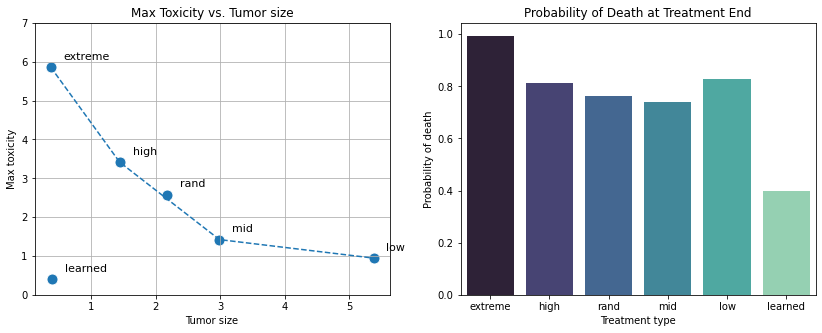

In [223]:
# Create the plot
fig2, ax = plt.subplots(nrows =  1, ncols=2, figsize = (14,5))

sns.scatterplot(x='end_tumor_size'
               , y= 'max_toxicity'
               , data = plot_df_summary
               , s=120
               , ax = ax[0]
               )

for i in range(plot_df_summary.shape[0]):
    ax[0].text(x=plot_df_summary.end_tumor_size[i]+0.2
            ,y=plot_df_summary.max_toxicity[i]+0.2
            ,s=plot_df_summary.index[i]
            , fontdict=dict(color='black', size=11)
            )

sns.lineplot(x = line_x
            , y = line_y
            , ax = ax[0])

ax[0].lines[0].set_linestyle("--")
ax[0].set(ylim=(0, 7))
ax[0].grid()
ax[0].set_title ('Max Toxicity vs. Tumor size')
ax[0].set_ylabel('Max toxicity')
ax[0].set_xlabel('Tumor size')

sns.barplot(y = 'prob_death'
            , x = plot_df_summary.index
            , data = plot_df_summary
            , ax =  ax[1]
            , palette = sns.color_palette("mako"))



ax[1].set_title ('Probability of Death at Treatment End')
ax[1].set_ylabel('Probability of death')
ax[1].set_xlabel('Treatment type')
plt.show()

In [ ]:
learned_policy_dic = {'max_toxicity': avg_max_toxicity
                      , 'end_tumor_size': avg_t_size
                      ,  'prob_death': avg_p_death
                       }

lrned_p_metrics_df = pd.DataFrame(learned_policy_dic, index=['learned'])   

def generate_evaluation_plot(init_state_set, learned_policy_metrics_df)

    # Create instance of the environment
    env = gym.make('ChemoSimulation-v0')

    # Dosage levels to test
    dosages =    {'low': np.array([0.1])
                , 'mid': np.array([0.4])
                , 'rand': None
                , 'high': np.array([0.7])
                , 'extreme': np.array([1.])}


    # Select the initial set of patients
    selected_patients = init_state_set

    # Dict to store patient information
    patient_dic = {}

    patient_count = 0

    # Run test for patients
    for patient in selected_patients:
        
        # Dict to store observations & prob. of death
        obs_dic = {}
        p_death_dic = {}
        
        # Run for each dosage level separately
        for level, dosage in dosages.items():

            # Create patient: initial Tumor size and wellness
            starting_state = np.array([patient[0]]),np.array([patient[1]])
            
            # St
            obs_dic[level] = []
            obs_dic[level].append(starting_state)
            env

            # Simulate the environment
            env.reset(init_state = starting_state)

            if level == 'rand':
                # Run treatment for 6 months
                for _ in range(7):
                    obs, reward, done, p_death = env.step(np.array([np.random.choice(np.array([0.1,0.4,0.7,1.]))]))
                
                    obs_dic[level].append(obs)
                    p_death_dic[level] = p_death
                    
                    if done:
                        break

            else:
                # Run treatment for 6 months
                for _ in range(7):
                    obs, reward, done, p_death = env.step(dosage)
                    
                    obs_dic[level].append(obs)
                    p_death_dic[level] = p_death
                    
                    if done:
                        break

    patient_dic[patient_count] = obs_dic, p_death_dic
    patient_count += 1
        
    ##############################################

    # Select data for the plot from each patient
    def get_stats(dic_vals):
        h_tox = np.array(dic_vals)[:,1].max()
        t_size = np.array(dic_vals)[-1,0][0]
        
        return h_tox, t_size

    # Dicts to store patient data during/at the end of treatment
    patient_data = {}
    patient_pdeath_data = {}

    for patient, patient_obs in patient_dic.items():
        
        plot_data = {}
        _pdeath_data = {}

        for level, obs in patient_obs[0].items():
            plot_data[level] = get_stats(obs)
            
        for level, pdeath in patient_obs[1].items():
            _pdeath_data[level] = pdeath

        patient_data[patient] = plot_data
        patient_pdeath_data[patient] = _pdeath_data


    # Aggregate data from every patient
    df_li = []
    for patient, plot_data in patient_data.items():
        tmp_df = pd.DataFrame(plot_data).T
        tmp_df.columns = ['max_toxicity', 'end_tumor_size']
        tmp_df.loc[:,'Patient'] = patient
        df_li.append(tmp_df)

    # Compute the averages
    plot_df = pd.concat(df_li,axis=0)
    plot_df.reset_index(inplace=True)

    plot_df_summary = plot_df.groupby(['index'])[['max_toxicity','end_tumor_size']].mean().reset_index()
    plot_df_summary.sort_values('end_tumor_size',inplace=True)
    plot_df_summary.set_index('index',inplace=True)

    # Compute prob. of death for each treatment-type
    pdeath_df = pd.DataFrame(pd.DataFrame(patient_pdeath_data).T.mean(axis=0))
    pdeath_df.columns = ['prob_death']

    # Prepare final eval. metric dataframe
    plot_df_summary = plot_df_summary.merge(right = pdeath_df
                                            , right_index=True
                                            , left_index=True)
    plot_df_summary

    # Join learned policy performance
    plot_df_summary = pd.concat([plot_df_summary, learned_policy_metrics_df])  

    ##########################################################
    ##################### Plotting data #####################

    # Data for the connecting line (excluding random dosage)
    line_y = plot_df_summary.loc[(plot_df_summary.index == 'extreme') \
                                | (plot_df_summary.index == 'high') \
                                | (plot_df_summary.index == 'mid') \
                                | (plot_df_summary.index == 'low'),'max_toxicity'].values

    line_x = plot_df_summary.loc[(plot_df_summary.index == 'extreme') \
                                | (plot_df_summary.index == 'high') \
                                | (plot_df_summary.index == 'mid') \
                                | (plot_df_summary.index == 'low') , 'end_tumor_size'].values     



    # Create the plot
    fig2, ax = plt.subplots(nrows =  1, ncols=2, figsize = (14,5))

    sns.scatterplot(x='end_tumor_size'
                , y= 'max_toxicity'
                , data = plot_df_summary
                , s=120
                , ax = ax[0]
                )

    for i in range(plot_df_summary.shape[0]):
        ax[0].text(x=plot_df_summary.end_tumor_size[i]+0.2
                ,y=plot_df_summary.max_toxicity[i]+0.2
                ,s=plot_df_summary.index[i]
                , fontdict=dict(color='black', size=11)
                )

    sns.lineplot(x = line_x
                , y = line_y
                , ax = ax[0])

    ax[0].lines[0].set_linestyle("--")
    ax[0].set(ylim=(0, 7))
    ax[0].grid()
    ax[0].set_title ('Max Toxicity vs. Tumor size')
    ax[0].set_ylabel('Max toxicity')
    ax[0].set_xlabel('Tumor size')

    sns.barplot(y = 'prob_death'
                , x = plot_df_summary.index
                , data = plot_df_summary
                , ax =  ax[1]
                , palette = sns.color_palette("mako"))



    ax[1].set_title ('Probability of Death at Treatment End')
    ax[1].set_ylabel('Probability of death')
    ax[1].set_xlabel('Treatment type')
    plt.show()  